# Base Boxplot for EDA
Recipes for Explodatory Data Analysis by means of plots

- toc: true 
- badges: true
- comments: false
- categories: [r,ggplot,recipes]


*TOC*
* write a function for generating data
* use melt for rearranging data
* create a base plot 
* add a boxplot to the base plot
* add a jiiter plot to the base plot
* write a function to automatically select points based on a custom filter
* perform a t.test on data and use ggpubr to add brackets to a boxplot 



In [1]:

#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
#  loading required libraries for this notebook
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

#loading libraries

library(ggplot2)
library(gridExtra)
library(data.table)
library(RColorBrewer)
library(ggpubr)
library(rstatix, warn.conflicts = FALSE)
library(ggrepel)
library(ggpubr)


In [2]:
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
#	creating a function for generating a dataset
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

# function for generating data with custom number of rows, means and sds

simpleDataset <- function(number_of_rows,means,sds)
{
l <- length(means)
res <- lapply(seq(1:l),function(x) 
	   eval(
	   parse(
	   text=paste("rnorm(",number_of_rows,",",means[x],",",sds[x],")",sep=""))
	   )
	   ) 
dat <- data.frame((sapply(res,c)))
id <- rownames(dat)
dat <-  cbind(id=id,dat)
dt <- data.table(dat)
return(dt)
}

dat1 <- simpleDataset(number_of_rows=30,
					  means=c(180,200,205),
				      sds=c(70,50,65))
				  
dat2 <- simpleDataset(number_of_rows=30,
					  means=c(180,200,205),
				      sds=c(85,45,35))
					  
dat <-  rbind(dat1,dat2)

# rearranging table using melt from data.table 

dt.melt <- melt(dat, id.vars="id")
colnames(dt.melt) <- c("id","category","var1")
dt.melt$ncat <- as.numeric(dt.melt$category)

#calculating statistics for adding brackets

stat.test <- dt.melt %>% t_test(var1 ~ ncat)
max_y <- round(max(dt.melt$var1))

In [3]:

#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
#	base plot settings								   
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

# IRKernel had a default output size of 7 x 7 inches and a resolution of 120 
# dpi each cell can have its own settings
# Keep in mind that if you would like to increase your dpi to get higher 
# quality # for printing, on screen your images will "look larger" 
# using the default settings like to have a base size of 24 in order to have
# big readable labels 

options(repr.plot.width=7, repr.plot.height=7)

base <- ggplot(dt.melt, 
			   aes(x=factor(ncat),
			       y=var1,
				   shape=category),
				   )								+	
				labs(title = "ggplot",
				    x		   = "xlab",
					y          = "ylab",
					subtitle = "subtitle",
					tag = "Fig.1")					+	
		theme_classic(base_size = 24)			 	+
		theme(legend.position = "none",
			  axis.text.x = element_text(face="bold"),
			  axis.text.y = element_text(face="bold"))
			  
			  
# options(repr.plot.width=14, repr.plot.height=7)
# p1 <- base+theme_classic(base_size = 16)
# #grid.arrange(p1,p1, ncol=2)

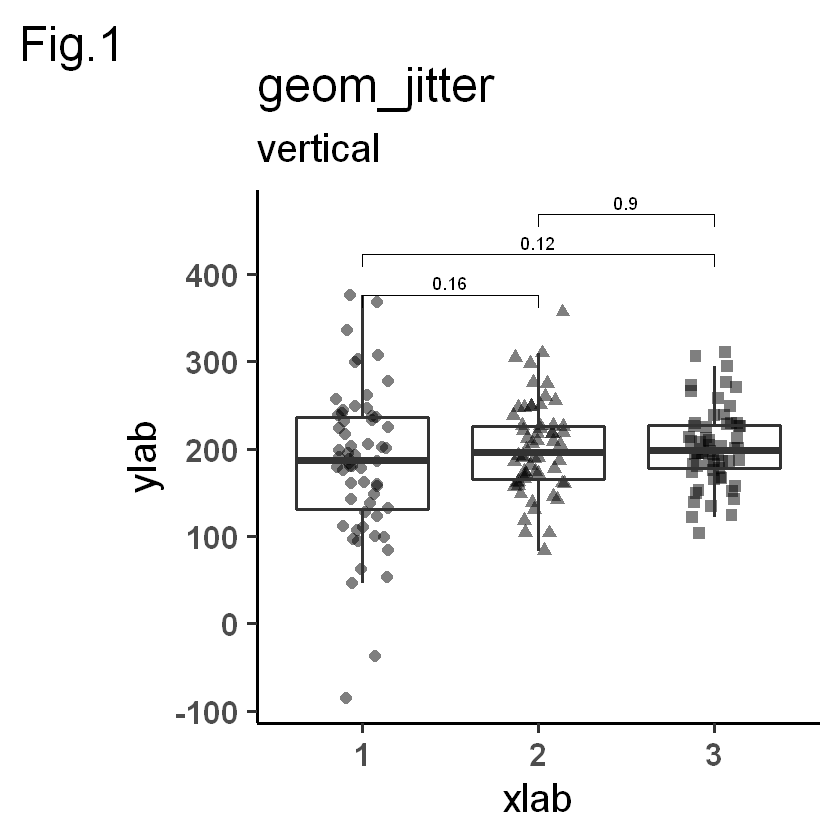

In [4]:
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
#	Jiitter plots + boxplot + brackets 
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

#adding jiitter plot
p <- base +
			geom_jitter(
						position = position_jitter(0.15),
						alpha=0.5, 
						size = 3
						) 									+
			labs		(title = "geom_jitter",
						subtitle =   "vertical") 			+
       
			geom_boxplot(alpha = 0,
						 lwd=1)								+
             
			scale_fill_grey(start = 0.8,
							end = 0.1) 						+
			geom_bracket( inherit.aes = FALSE,
						  aes(
						  xmin = group1,
						  xmax = group2,
						  label = signif(p, 2)
						  ),
						  data = stat.test,
						  y.position = max_y,
						  step.increase = 0.1)			 	#+
			#aes(color = factor(ncat))						 +
			#scale_color_brewer(palette="Reds")

#uncomment tthe latest two lines if you want colors
p

In [5]:

#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°
# Functions for Adding Labels
#+++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°+++++++++°

set_lab_jitt <- function(dt.melt, sel_cat, uplim, lowlim,...){
							p <- geom_text_repel(
							data=dt.melt[category==sel_cat],
							aes(
							label=ifelse(((var1 > uplim | var1 < lowlim )),
							as.character(id),'')),
							)
							}

#pv + set_lab_jitt(dt.melt,"X1",180,50)
#position = position_jitter(0.2,seed = 1)

#using gg_text_repel in order to better visualize the labels
			
# creating functions to highlight data depending on n sigma or
# a delta from the min and max 

NormTextlim <- function(x, nsigma){
					limup   <- mean(x)  + nsigma*sd(x)
					limlow  <- mean(x) - nsigma*sd(x)
					l       <- list("limup"=limup,"limlow"=limlow)
					return(l)
					}
					
Utextlim <- function(x, ndiv){
					nth_div <- (max(x)-min(x))/ndiv
					limup   <- max(x)  - nth_div
					limlow  <- min(x)  + nth_div
					l       <- list("limup"=limup,"limlow"=limlow)
					return(l)
					}

# creating a category index
unique_category <- unique(dt.melt$category)		
# if outliers are present you can extract their id using 
# the function ggbuild see
# https://stackoverflow.com/a/58936654/6483091
#out <- ggplot_build(g)[["data"]][[1]][["outliers"]]
